# Checking heritability computed on DNAm

In [4]:
library(here)
library(data.table)
library(tidyverse)
library(parallel)
library(glue)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

Warning message:
“package ‘tibble’ was built under R version 4.1.1”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::collapse()  masks glue::collapse()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()



probe,V(G),V(e),Vp,V(G)/Vp,logL,logL0,LRT,Pval,V(G)_SE,V(e)_SE,Vp_SE,V(G)/Vp_SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cg00000029,0.014699,0.176618,0.191317,0.076832,41.664,37.479,8.370,1.91e-03,0.010041,0.016250,0.017702,0.049899
cg00000108,0.336076,0.072536,0.408613,0.822481,90.523,-21.504,224.053,0.00e+00,0.069762,0.007647,0.069107,0.035863
cg00000109,0.000000,0.080807,0.080807,0.000001,148.617,148.617,0.000,5.00e-01,0.001653,0.007277,0.007129,0.020453
cg00000165,0.001287,0.106842,0.108129,0.011907,111.422,111.331,0.183,3.34e-01,0.003213,0.009780,0.009558,0.029633
cg00000236,0.001661,0.059108,0.060769,0.027332,186.183,185.565,1.236,1.33e-01,0.002108,0.005383,0.005415,0.034262
cg00000289,0.050336,0.071638,0.121974,0.412679,129.968,105.339,49.257,1.12e-12,0.015407,0.007401,0.015317,0.084071


[1] 164434

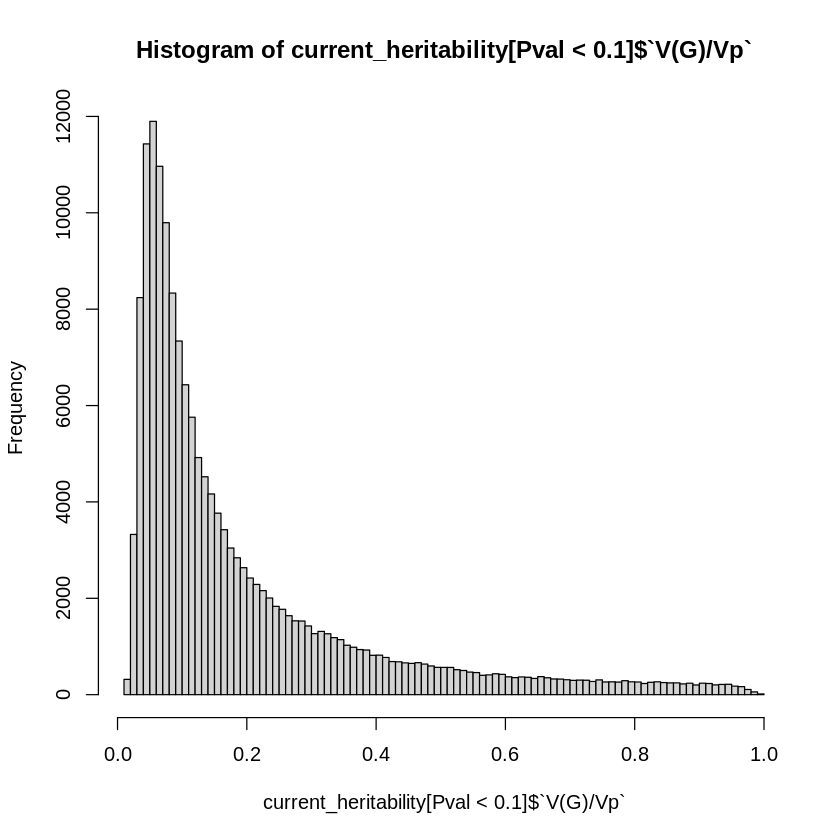

In [5]:
if(file.exists(here("data","cis_heritability.txt.gz"))){
    current_heritability <- fread(here("data","cis_heritability.txt.gz"))
}else{
    h_files <- dir(here("data", "gcta_analysis", "delahaye_output"))
    cpgs <- gsub(".hsq", "", h_files)

    read_heritability <- function(fname){
        dt <- fread(fname,fill=TRUE)
        main_cols <- transpose(dt[1:8,c(2)])
        colnames(main_cols) <- dt$Source[1:8]
        se_cols <- transpose(dt[1:4,c(3)])
        colnames(se_cols) <- paste0(dt$Source[1:4],"_SE")
        return(cbind(data.table(probe=gsub(".*/(.*).hsq","\\1",fname)),main_cols,se_cols))
    }
    current_heritability <- rbindlist(
        mclapply(
            here("data","gcta_analysis","delahaye_output",h_files),
            read_heritability,
            mc.cores = 32
        )
    )
   fwrite(current_heritability,here("data","cis_heritability.txt.gz"),sep='\t',quote=FALSE,row.names=FALSE)
}

head(current_heritability)

nrow(current_heritability[Pval < 0.10])
hist(current_heritability[Pval < 0.10]$`V(G)/Vp`,breaks=100)

## Create mQTL annotation filtering CAVIAR results with heritable CpGs

In [31]:
generate_annotation <- function(mQTL_annot, baseline_annot_f,chrom,annot){
    baseline_annot <- fread(baseline_annot_f)
    tmp <- mQTL_annot[current_heritability[Pval < 0.1]$probe,on="probe"][CHR == chrom]
    if(annot == "bin_CPP"){
        merged <- merge(
            baseline_annot,
            tmp[,.(bin_CPP=ifelse(any(CPP>0),1,0)),by="SNP"],
            by="SNP",all.x=TRUE,sort = FALSE)
        merged[, `:=`(bin_CPP = ifelse(is.na(bin_CPP),0,bin_CPP))]
        return(merged[,.(CHR,BP,SNP,CM,bin_CPP)])    
    }else if(annot == "maxCPP"){
        merged <- merge(
            baseline_annot,
            tmp[,.(maxCPP=max(CPP)),by="SNP"],
               by="SNP",all.x=TRUE,sort = FALSE)
        merged[, `:=`(maxCPP = ifelse(is.na(maxCPP),0,maxCPP))]
        return(merged[,.(CHR,BP,SNP,CM,maxCPP)])    
    }else if (annot == "all_cis"){ # @todo Edit this for final threshold table
        merged <- merge(
            baseline_annot,
            tmp[,.(all_cis=ifelse(any(FDR < 0.05),1,0)),by="SNP"],by="SNP",all.x=TRUE,sort = FALSE)
        merged[, `:=`(all_cis = ifelse(is.na(all_cis),0,all_cis))]
        return(merged[,.(CHR,BP,SNP,CM,all_cis)])    
        
    }else{
        print("NO ANNOTATION SELECTED")
        return(NULL)
    }
}

# build all annotations except male and female specific
for(annot in c("bin_CPP","maxCPP")){
    for(cur_mqtl in c("marginal","sex_interaction","male","female", "cord_mqtl")){
        if(cur_mqtl == "cord_mqtl"){
            mQTL_annot <- fread(glue("../data/{cur_mqtl}_caviar.txt.gz"))    
        }else{
            mQTL_annot <- fread(glue("../data/{cur_mqtl}_meta_caviar_maf01.txt.gz"))
        }
        cur_annot <- mclapply(
            1:22,
            function(i){
                generate_annotation(
                    mQTL_annot,
                    glue("../../1000G_v2.2_baseline/baselineLD.{i}.annot.gz"),
                    glue("{i}"),
                    annot
                )
            },
            mc.cores=16
        ) 
        mclapply(1:22, function(i)
            fwrite(
                cur_annot[[i]],
                glue("/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/single_delahaye_annotations/{cur_mqtl}_{annot}_her.{i}.annot.gz"),
                sep='\t',quote=FALSE,row.names=FALSE
            ),
            mc.cores=16
        )
    }
}

Next steps carried out elsewhere:
1. Partition new LD scores
1. Compute stratified LD score regression with each annotation on PGC traits

## Plotting new LDSC results

In [37]:
gwas_sample_sizes <- function(f){
    N <- fread(f,nrows=1)$N
    GWAS <- str_match(f,".*/(.*).sumstats.gz")[2]
    return(data.table(GWAS=GWAS,N=N))
}
part_heritability_results <- function(path){
    lapply(
          dir(
            path,
            pattern = ".*_shared.results$",
            full.names = TRUE
          ),
          function(f) {
            labels <- str_match(f, ".*/(all_cis|bin_CPP_her|maxCPP_her)_(.*)_shared.results")[-c(1)]
            if (any(is.na(labels))) {
              return(data.table())
            } else {
              dt <- fread(f)
              dt[, 
                `:=`(
                  Coefficient_p=pnorm(abs(`Coefficient_z-score`),lower.tail=F)*2,
                  annotation = labels[1],
                  GWAS = labels[2])]
              return(dt)
            }
          }
        )
}


pgc_part_heritability_df <- rbindlist(part_heritability_results("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/ldsc_meta_EUR_pgc_results/"))

pgc_GWAS_key <- c(
    "adhd_jul2017" = "ADHD",
    "pgc_adhd_males" = "ADHD Males",
    "pgc_adhd_females" = "ADHD Females",
    "pts_all_freeze2_overall.results" = "PTSD",
    "pts_all_freeze2_males.results" = "PTSD Males",
    "pts_all_freeze2_females.results" = "PTSD Females",
    "iPSYCH-PGC_ASD_Nov2017" = "ASD",
    "NEW_META_PGC_iPSYCH_ASD_males" = "ASD Males",
    "NEW_META_PGC_iPSYCH_ASD_females" = "ASD Females",
    "PGC_UKB_depression_genome-wide.txt" = "MDD",
    "meta_STDERR_mdd_eur_auto_M1_08_gcOFF_pgc.txt" = "MDD Males",
    "meta_STDERR_mdd_eur_auto_F1_08_gcOFF_pgc.txt" = "MDD Females",
    "ocd_aug2017" = "OCD",
    "anxiety.meta.full.cc.tbl" = "ANX",
    "anxiety.meta.full.fs.tbl" = "ANXFS",
    "pgc_bip_2018" = "BIP",
    "PGC3_SCZ_wave3_public.v2.tsv" = "SCZ",
    "pgcAN2.2019-07.vcf.tsv" = "AN",
    "TS_Oct2018" = "TS",
    "pgc.cross.full.2013-03.txt" = "Cross Disorder",
    "AUDIT_UKB_2018_AJP.txt" = "Alcohol (AUDIT)",
    "pgc_alcdep.eur_unrelated.aug2018_release.txt" = "ALC",
    "Cannabis_ICC_23andmetop_UKB_het.txt" = "Cannabis",
    "tag.cpd.tbl" = "Cigarettes Per Day"
)
compulsive <- c(
    "pgcAN2.2019-07.vcf.tsv" = "AN",
    "ocd_aug2017" = "OCD",
    "TS_Oct2018" = "TS"
)
psychotic <- c(
    "pgc_bip_2018" = "BIP",
    "PGC3_SCZ_wave3_public.v2.tsv" = "SCZ",
    "pgc_alcdep.eur_unrelated.aug2018_release.txt" = "ALC"
)
neurodevelopmental <- c(
    "TS_Oct2018" = "TS",
    "pgc_alcdep.eur_unrelated.aug2018_release.txt" = "ALC",
    "adhd_jul2017" = "ADHD",
    "iPSYCH-PGC_ASD_Nov2017" = "ASD",
    "pts_all_freeze2_overall.results" = "PTSD",
    "PGC_UKB_depression_genome-wide.txt" = "MDD"
)
internalizing <- c(
    "pts_all_freeze2_overall.results" = "PTSD",
    "PGC_UKB_depression_genome-wide.txt" = "MDD",
    "anxiety.meta.full.cc.tbl" = "ANX",
    "anxiety.meta.full.fs.tbl" = "ANXFS"
)
substance_set <- c(
    "pgc_alcdep.eur_unrelated.aug2018_release.txt" = "ALC",
    "Cannabis_ICC_23andmetop_UKB_het.txt" = "Cannabis",
    "tag.cpd.tbl" = "Cigarettes Per Day",
    "AUDIT_UKB_2018_AJP.txt" = "Alcohol (AUDIT)"
)

sex_stratified_set <- c(
    "adhd_jul2017" = "ADHD",
    "pgc_adhd_males" = "ADHD Males",
    "pgc_adhd_females" = "ADHD Females",
    "pts_all_freeze2_overall.results" = "PTSD",
    "pts_all_freeze2_males.results" = "PTSD Males",
    "pts_all_freeze2_females.results" = "PTSD Females",
    "iPSYCH-PGC_ASD_Nov2017" = "ASD",
    "NEW_META_PGC_iPSYCH_ASD_males" = "ASD Males",
    "NEW_META_PGC_iPSYCH_ASD_females" = "ASD Females",
    "PGC_UKB_depression_genome-wide.txt" = "MDD",
    "meta_STDERR_mdd_eur_auto_M1_08_gcOFF_pgc.txt" = "MDD Males",
    "meta_STDERR_mdd_eur_auto_F1_08_gcOFF_pgc.txt" = "MDD Females"
)
pgc_part_heritability_df <- pgc_part_heritability_df %>% mutate(
        significant_coef = Coefficient_p < 0.05, 
        significant_enrich = Enrichment_p < 0.05,
        GWAS = recode(GWAS, !!!pgc_GWAS_key),
        Category = recode(Category,L2_0="Marginal",L2_1="Sex Interaction", L2_2= "Male", L2_3="Female", L2_4='Cord Blood')
    ) %>%
    mutate(GWAS = factor(GWAS,levels=pgc_GWAS_key))

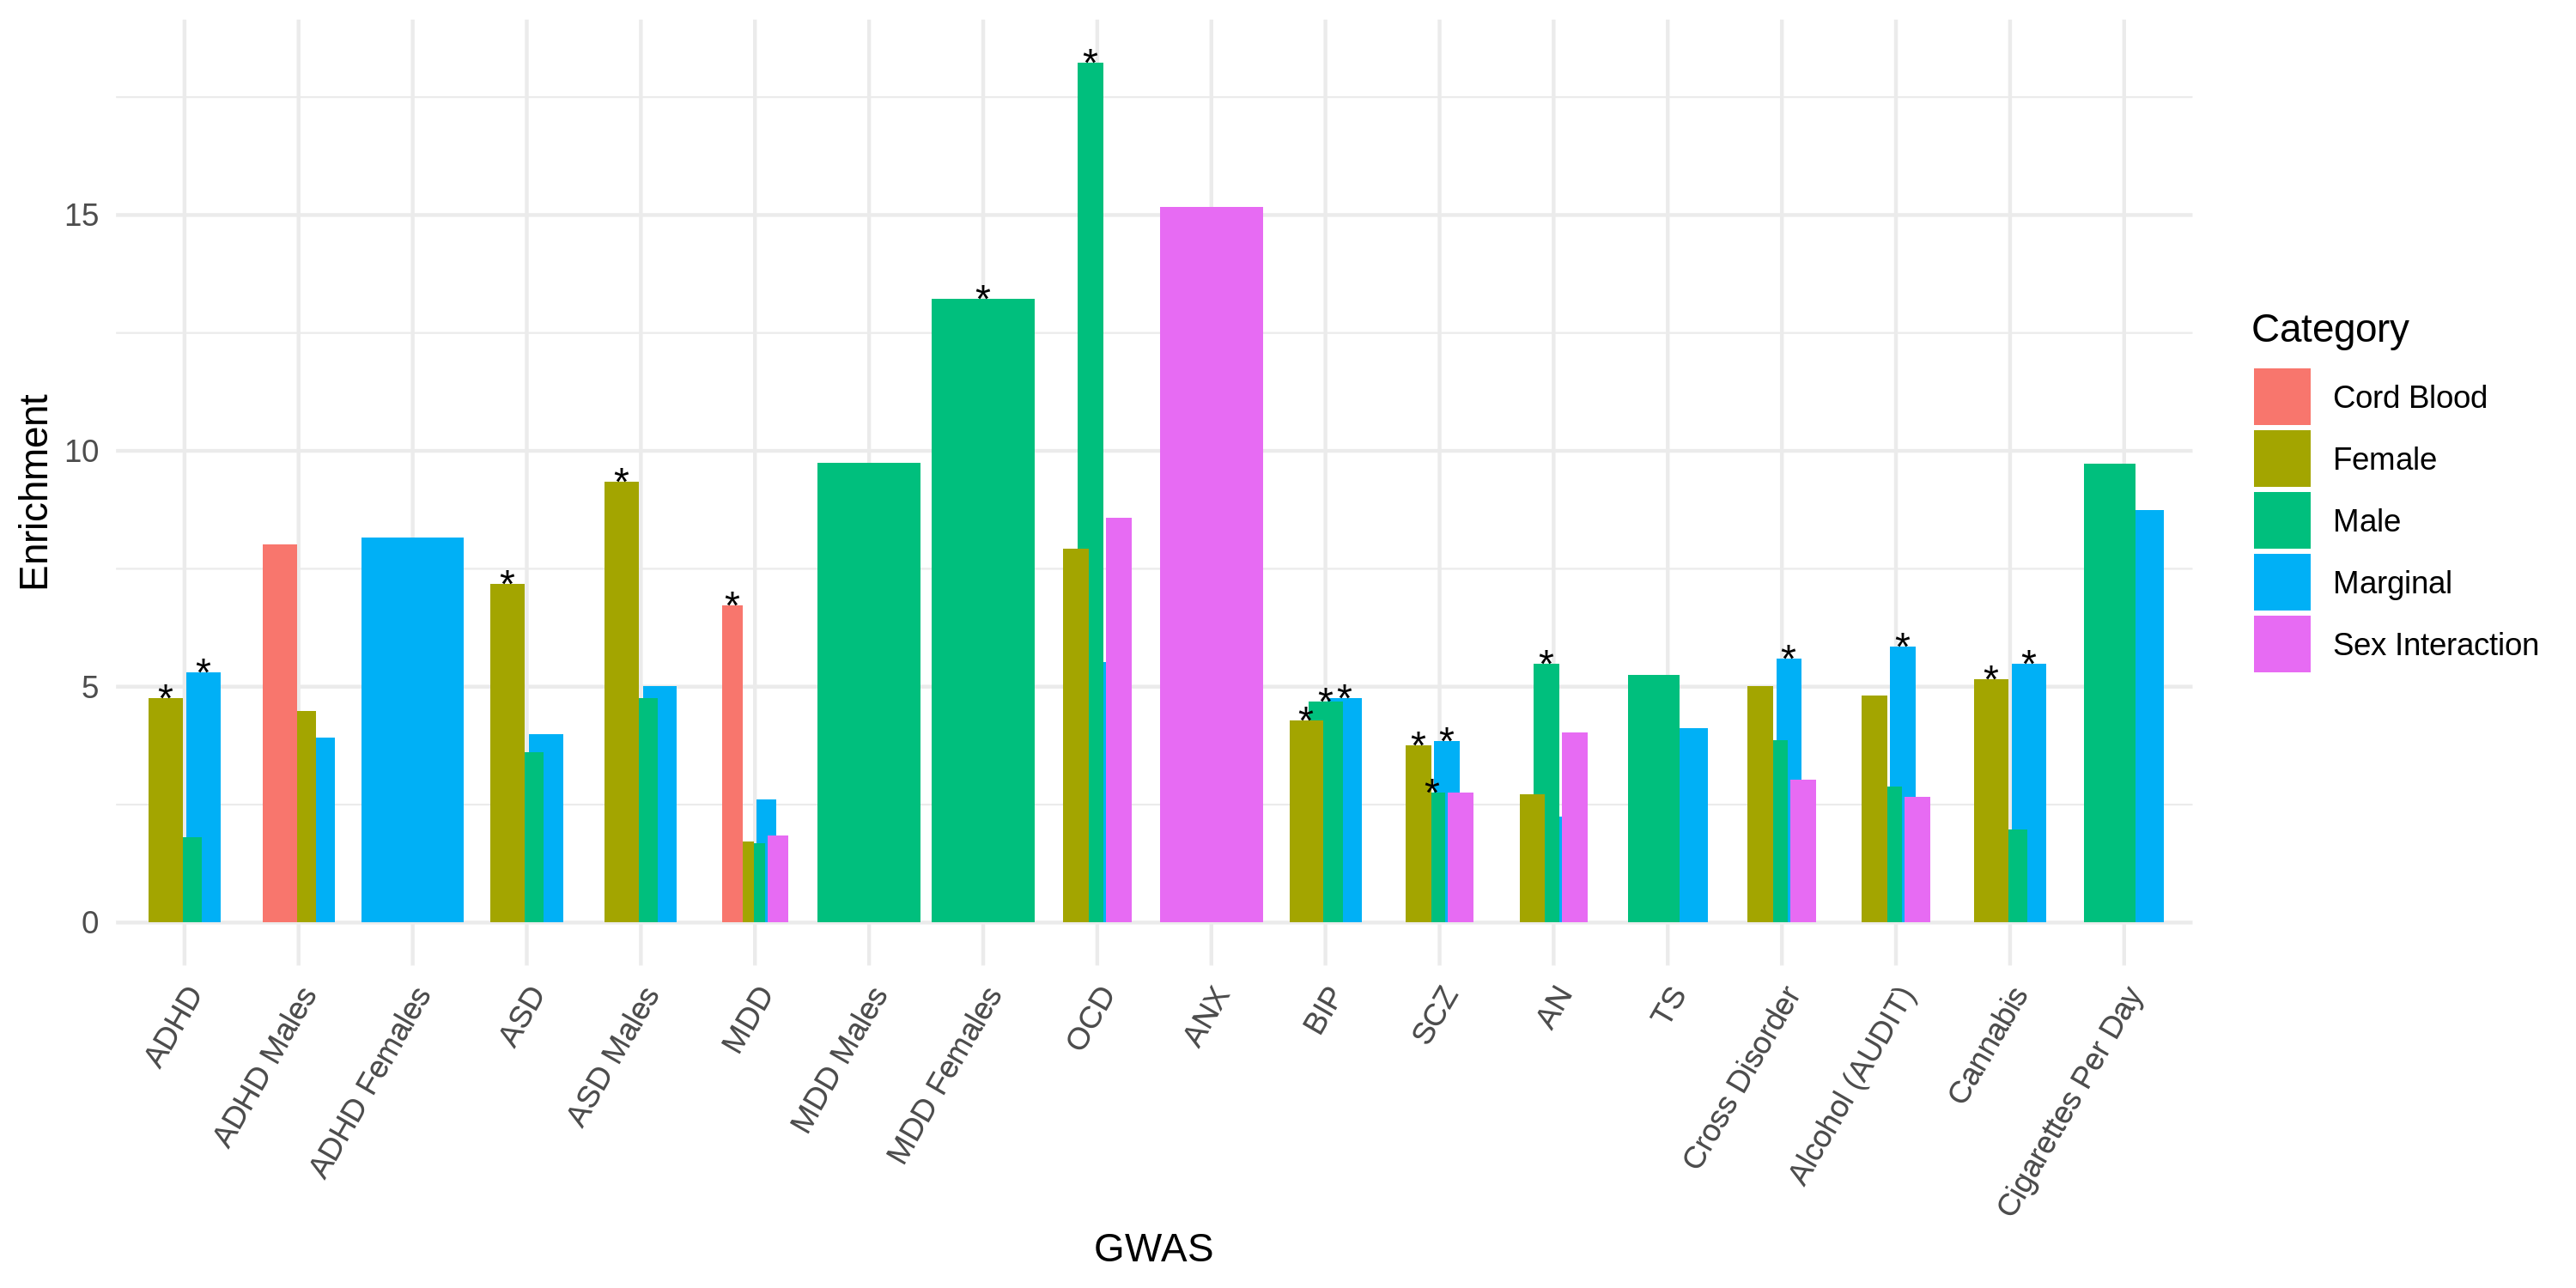

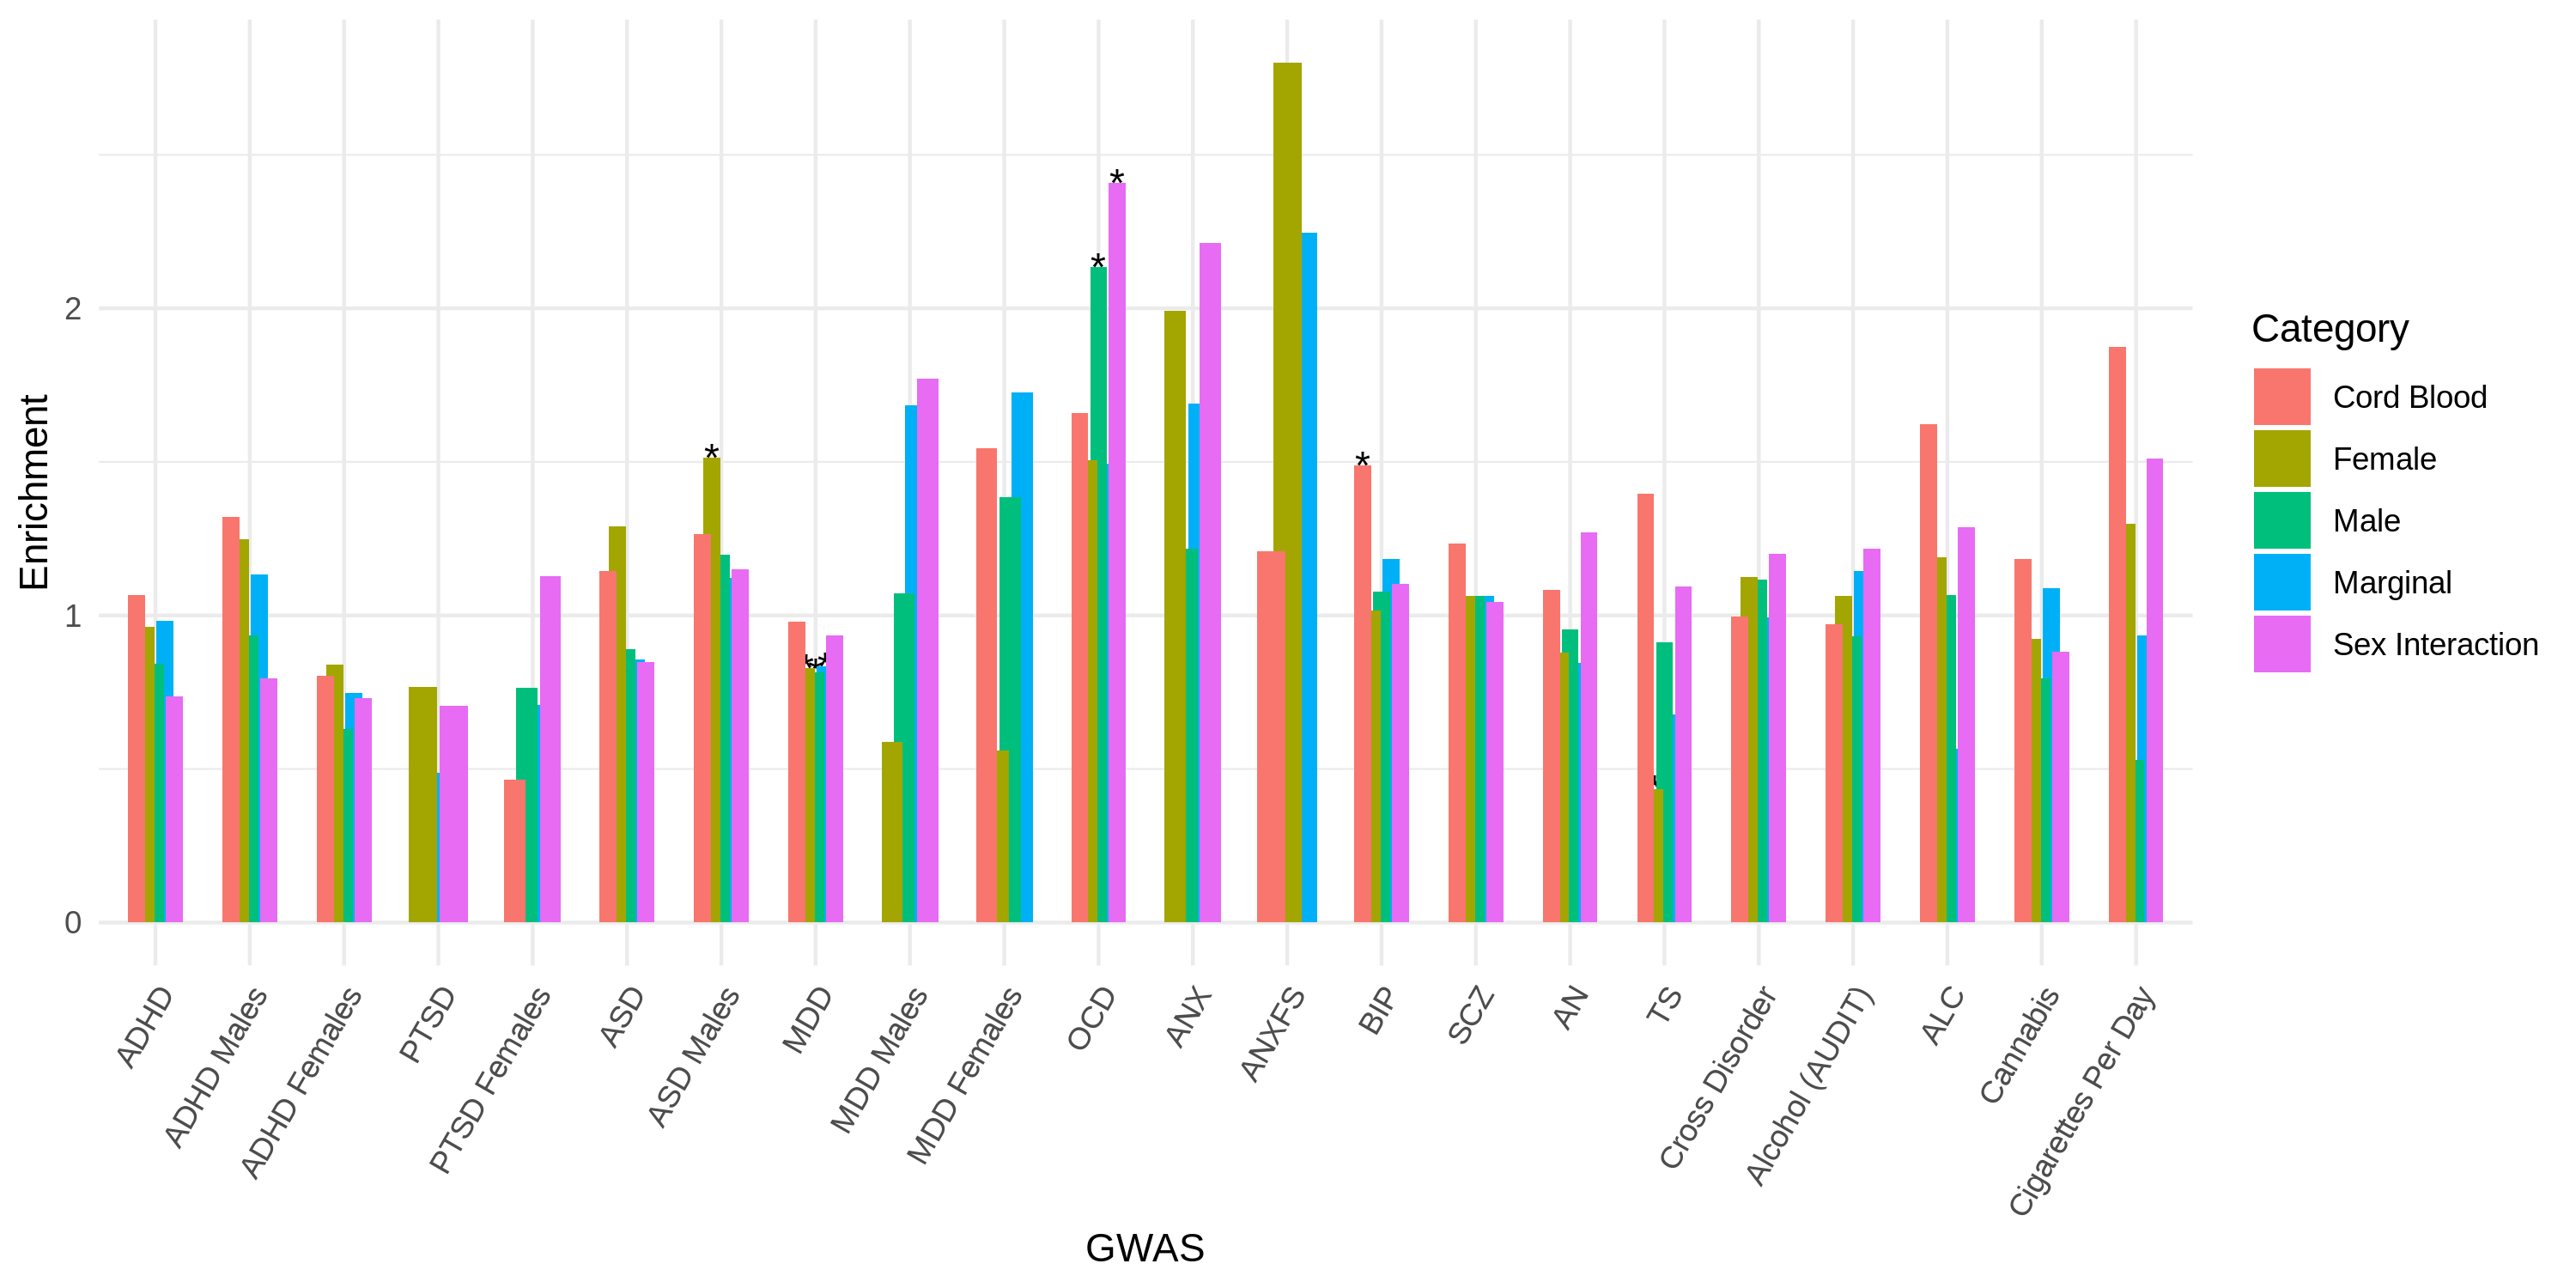

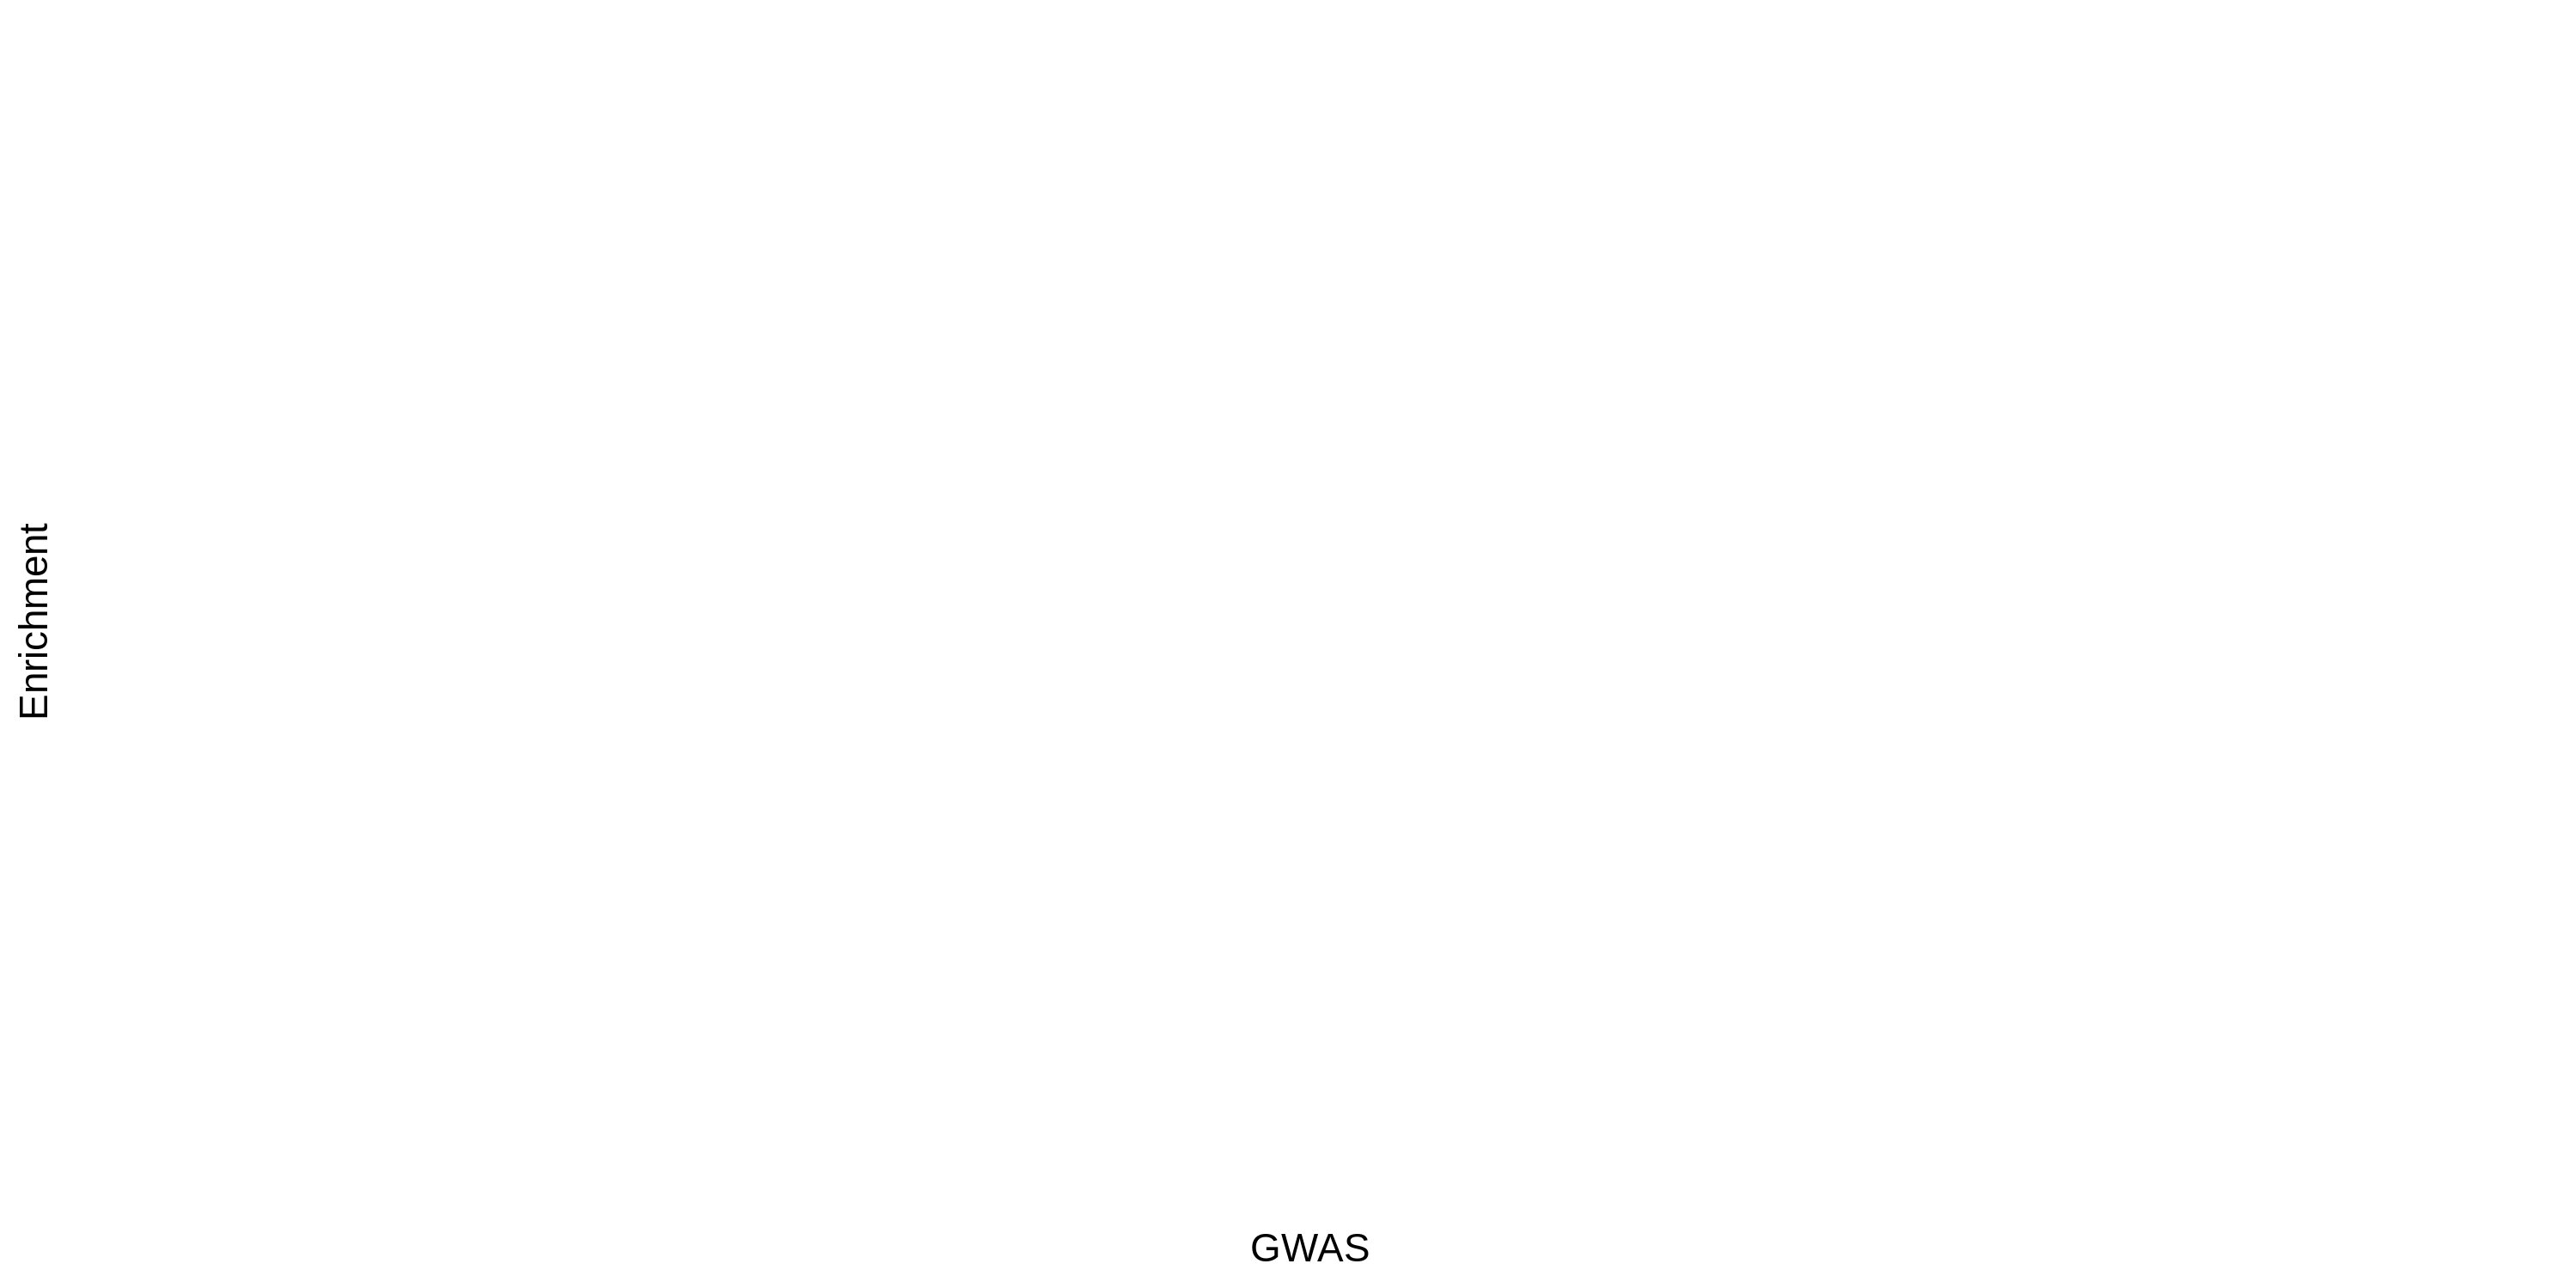

In [80]:
options(repr.plot.width= 10, repr.plot.height= 5, repr.plot.res = 300)

ggplot(
    pgc_part_heritability_df[
        !GWAS %in% c("PTSD Males","ASD Females") &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female", "Cord Blood") &
        annotation == "maxCPP_her" &
        Enrichment - Enrichment_std_error > 0
    ],
    aes(fill = Category, x=GWAS,y=Enrichment,label = ifelse(significant_enrich,"*","")))+
    geom_col(position=position_dodge(width=0.5)) + 
    geom_text(position=position_dodge(width=0.5))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

ggplot(
    pgc_part_heritability_df[
        !GWAS %in% c("PTSD Males","ASD Females") &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female", "Cord Blood") &
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0
    ],
    aes(fill = Category, x=GWAS,y=Enrichment,label = ifelse(significant_enrich,"*","")))+
    geom_text(position=position_dodge(width=0.5))+
    geom_col(position=position_dodge(width=0.5))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

ggplot(
    pgc_part_heritability_df[
        !GWAS %in% c("PTSD Males","ASD Females") &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female", "Cord Blood") &
        annotation == "all_cis" &
        Enrichment - Enrichment_std_error > 0
    ],
    aes(fill = Category, x=GWAS,y=Enrichment,label = ifelse(significant_enrich,"*","")))+
    geom_text(position=position_dodge(width=0.5))+
    geom_col(position=position_dodge(width=0.5))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

In [47]:
pgc_part_heritability_df[Category == "baseL2_5"]

Category,Prop._SNPs,Prop._h2,Prop._h2_std_error,Enrichment,Enrichment_std_error,Enrichment_p,Coefficient,Coefficient_std_error,Coefficient_z-score,Coefficient_p,annotation,GWAS,significant_coef,significant_enrich
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<lgl>,<lgl>
baseL2_5,1,1,0.000000e+00,1,0.000000e+00,NA,4.227785e-08,6.966965e-08,0.606833126,0.5439616617,bin_CPP_her,ADHD,FALSE,NA
baseL2_5,1,1,5.452812e-07,1,5.452812e-07,NA,4.222666e-09,1.529142e-07,0.027614605,0.9779695333,bin_CPP_her,ANX,FALSE,NA
baseL2_5,1,1,6.096629e-07,1,6.096629e-07,NA,7.967858e-08,1.066567e-07,0.747056414,0.4550295084,bin_CPP_her,ANXFS,FALSE,NA
baseL2_5,1,1,0.000000e+00,1,0.000000e+00,NA,-1.008720e-08,1.463654e-08,-0.689179043,0.4907106031,bin_CPP_her,Alcohol (AUDIT),FALSE,NA
baseL2_5,1,1,5.366128e-08,1,5.366128e-08,NA,1.346808e-08,2.257933e-08,0.596478460,0.5508556397,bin_CPP_her,Cannabis,FALSE,NA
baseL2_5,1,1,1.186258e-07,1,1.186258e-07,NA,-2.146878e-08,5.229649e-08,-0.410520419,0.6814242282,bin_CPP_her,ASD,FALSE,NA
baseL2_5,1,1,2.527739e-07,1,2.527739e-07,NA,-6.925359e-08,1.065132e-07,-0.650187930,0.5155708368,bin_CPP_her,MDD Females,FALSE,NA
baseL2_5,1,1,0.000000e+00,1,0.000000e+00,NA,-1.210958e-07,1.437282e-07,-0.842533533,0.3994893780,bin_CPP_her,MDD Males,FALSE,NA
baseL2_5,1,1,0.000000e+00,1,0.000000e+00,NA,6.259067e-08,1.868986e-07,0.334890986,0.7377073218,bin_CPP_her,ASD Females,FALSE,NA
